In [1]:
#open this notebook in environment by running following in terminal:
# source ~/miniconda/bin/activate
# jupyter notebook

In [ ]:
#!pip install nibabel
#!pip install matplotlib
#!pip install opencv-python

In [1]:
import numpy as np
import cv2
import math
from random import sample
from glob import glob
import os

import json 
import nibabel as nib
import nibabel.processing 
from nibabel.processing import resample_to_output
import nilearn

import matplotlib.pyplot as plt
import PIL
from PIL import Image

from os import listdir
from os.path import isfile, join

import tensorflow as tf
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from nilearn.image import concat_imgs, mean_img, resample_img

import tensorflow as tflow
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
!ls '../kits21/kits21/data/'

case_00000 case_00043 case_00086 case_00129 case_00172 case_00215 case_00258
case_00001 case_00044 case_00087 case_00130 case_00173 case_00216 case_00259
case_00002 case_00045 case_00088 case_00131 case_00174 case_00217 case_00260
case_00003 case_00046 case_00089 case_00132 case_00175 case_00218 case_00261
case_00004 case_00047 case_00090 case_00133 case_00176 case_00219 case_00262
case_00005 case_00048 case_00091 case_00134 case_00177 case_00220 case_00263
case_00006 case_00049 case_00092 case_00135 case_00178 case_00221 case_00264
case_00007 case_00050 case_00093 case_00136 case_00179 case_00222 case_00265
case_00008 case_00051 case_00094 case_00137 case_00180 case_00223 case_00266
case_00009 case_00052 case_00095 case_00138 case_00181 case_00224 case_00267
case_00010 case_00053 case_00096 case_00139 case_00182 case_00225 case_00268
case_00011 case_00054 case_00097 case_00140 case_00183 case_00226 case_00269
case_00012 case_00055 case_00098 case_00141 case_00184 case_00227 case_00270

(50, 512, 512)
[0. 1. 2.]


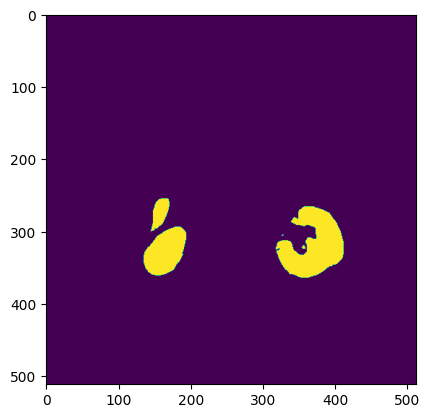

In [4]:
def generate_image_paths(rootdir_str, general_filename):
    """ Creates list of paths to images in each subfolder and corresponsing patient ID """
    
    paths_list = []
    
    for file in os.listdir(rootdir_str):
        d = os.path.join(rootdir_str, file)
        if os.path.isdir(d):
            paths_list.append(d + general_filename)
            
    return paths_list

In [5]:
def load_nifti_img_and_mask_as_numpy(paths_list):
    """ Loads nifti images corresponding to paths lists in a dictionary 
    of case_id as keys and 3D numpy image arrays as values. Filters list by  """

    image_dict = {}

    for img_path in paths_list:
        case_id = img_path[22:32]
        ct_nii = nib.load(img_path).get_fdata()
        #ct_nii = np.load(img_path, allow_pickle=True)
        image_dict[case_id] = ct_nii
    
    return image_dict


#print(len(image_case_dict) == len(mask_case_dict))

In [6]:
#identifying images to remove based on if they have kidney or tumor in the image.

def remove_images_without_kidney(dictionary_3D_images, dictionary_3D_masks):
    """Based on mask presence of segmentation values in mask images; identifies indexes of 
    empty masks and removes them from given images and masks dictionaries"""
    
    idx_remove_dict = {}
    
    #identifying position of images to remove from image dictionary
    for key, value in dictionary_3D_masks.items():
        idx_list = []
        
        #checks max value in mask in each 3D image volume and saves idexes of images to remove
        for idx, img in enumerate(value):
            if np.max(img) == 0.0:
                idx_list.append(idx)
                
        idx_remove_dict[key] = idx_list
        
    #removing images corresponding to "empty" mask images
    for key, value in idx_remove_dict.items():
        dictionary_3D_images[key] = np.delete(dictionary_3D_images[key], value, axis=0)
        dictionary_3D_masks[key] = np.delete(dictionary_3D_masks[key], value, axis=0)
    
    return dictionary_3D_images, dictionary_3D_masks

In [7]:
#Preprocessing: downsample images and normalizing

def image_preprocessing(dictionary_3D_images, normalize = True ):
    """ Downsamples images and masks to 224x224 and normalize pixel values 
    to range of 0 to 1."""
    
    for key, value in dictionary_3D_images.items():
        image_list = []
        print(np.unique(value))
        
        for img in value:
            img_preprocessed = cv2.resize(img, dsize=(64, 64), interpolation = cv2.INTER_NEAREST) #128x128 -> 224x224 -> 32*?
            
            if normalize == True:
                img_preprocessed = cv2.normalize(img_preprocessed, None, 0, 1, cv2.NORM_MINMAX)
            image_list.append(img_preprocessed)
            
       
        #print("image list", np.unique(image_list))
        
        dictionary_3D_images[key] = np.array(image_list)
        #print("last in image", np.unique(dictionary_3D_images[key]))
        
    return dictionary_3D_images

#images_dict_preprocessed = image_preprocessing(image_dict)
#masks_dict_preprocessed = image_preprocessing(mask_dict, False)

In [8]:
def save_images(dir_name, img_dict):
    prep_folder = 'preprocessed-data'
    
    if not os.path.exists(prep_folder):
        os.makedirs(prep_folder)
    
    if not os.path.exists(prep_folder + '/' + dir_name):
        os.makedirs(prep_folder + '/' + dir_name)
    
    for key, value in img_dict.items():
        #ni_img = nib.Nifti1Image(value, affine=np.eye(4))
        #nib.save(ni_img, prep_folder +'/'+ dir_name + '/' + key + '.nii.gz')      
        np.save(prep_folder +'/'+ dir_name + '/' + key + '.npy', value)
        #ct_nii = np.load('./preprocessed-data/images/case_00011.npy')

    return None

In [9]:
def chunk_process_images(rootdir, image_str, mask_str, chunk_size):
    
    paths_list_images = generate_image_paths(rootdir, image_str)
    paths_list_masks = generate_image_paths(rootdir, mask_str)
    
    paths_list_images = paths_list_images
    paths_list_masks = paths_list_masks
    
    image_dict_preprocessed, mask_dict_preprocessed = {}, {}
    #slices list into sublist of size chunk_size and remaining elements
    for i in range(0, len(paths_list_images), chunk_size):
        chunk_img = paths_list_images[i:i + chunk_size]
        chunk_mask = paths_list_masks[i:i + chunk_size]
        print(chunk_img)
        
        image_dict = load_nifti_img_and_mask_as_numpy(chunk_img)
        mask_dict = load_nifti_img_and_mask_as_numpy(chunk_mask)
        
        image_dict, mask_dict = remove_images_without_kidney(
            image_dict, mask_dict)
            
        image_dict_preprocessed_sub = image_preprocessing(image_dict, normalize = True)
        mask_dict_preprocessed_sub = image_preprocessing(mask_dict, normalize = False)
        
        save_images('images', image_dict_preprocessed_sub)
        save_images('masks', mask_dict_preprocessed_sub)
    
    return "Ran without error"

In [10]:
#print(image_dict_preprocessed.keys())

In [11]:
#img = image_dict_preprocessed['case_00141']
#print(test.shape)
#test = img[40,:,:]
#plt.imshow(test)

In [12]:
# ----------- Creating image paths ----------


#image_paths_list = generate_image_paths(rootdir, '/imaging.nii.gz')
#mask_paths_list = generate_image_paths(rootdir, '/aggregated_AND_seg.nii.gz')

#print(len(image_paths_list) == len(mask_paths_list))

#image_case_dict = load_nifti_img_and_mask_as_numpy(image_paths_list[:20])
#mask_case_dict = load_nifti_img_and_mask_as_numpy(mask_paths_list[:20])


# ----------- Removing irrelevant images ----------
#image_dict, mask_dict = remove_images_without_kidney(image_case_dict, mask_case_dict) 


# ----------- Preprocessing and saving images ----------
rootdir = '../kits21/kits21/data/'
chunk_process_images(rootdir, '/imaging.nii.gz', '/aggregated_AND_seg.nii.gz', 10)

['../kits21/kits21/data/case_00179/imaging.nii.gz', '../kits21/kits21/data/case_00146/imaging.nii.gz', '../kits21/kits21/data/case_00141/imaging.nii.gz', '../kits21/kits21/data/case_00148/imaging.nii.gz', '../kits21/kits21/data/case_00183/imaging.nii.gz', '../kits21/kits21/data/case_00177/imaging.nii.gz', '../kits21/kits21/data/case_00170/imaging.nii.gz', '../kits21/kits21/data/case_00184/imaging.nii.gz', '../kits21/kits21/data/case_00124/imaging.nii.gz', '../kits21/kits21/data/case_00123/imaging.nii.gz']
[-1024. -1023. -1022. ...  1280.  1284.  1292.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  1392.  1402.  1469.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  1495.  1512.  1532.]
[-1024. -1023. -1022. ...  1546.  1603.  1638.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  2036.  2042.  2077.]
[-2048. -1024. -1023. ...  1376.  1379.  1408.]
[-2048. -1024. -1023. ...  1179.  1180.  1183.]
[0. 1. 2.

[-1024. -1023. -1022. ...  1349.  1351.  1360.]
[-1024. -1023. -1022. ...  1132.  1137.  1163.]
[-1024. -1023. -1022. ...  1242.  1257.  1311.]
[-1024. -1023. -1022. ...  1198.  1200.  1201.]
[-1024. -1023. -1022. ...  1534.  1543.  1556.]
[-1024. -1023. -1022. ...  1475.  1489.  1499.]
[-1024. -1023. -1022. ...  1538.  1545.  1549.]
[-1024. -1023. -1022. ...  1760.  1774.  1790.]
[-1024. -1023. -1022. ...  1613.  1691.  1734.]
[-2048. -1024. -1023. ...  1181.  1183.  1202.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
['../kits21/kits21/data/case_00215/imaging.nii.gz', '../kits21/kits21/data/case_00027/imaging.nii.gz', '../kits21/kits21/data/case_00020/imaging.nii.gz', '../kits21/kits21/data/case_00212/imaging.nii.gz', '../kits21/kits21/data/case_00080/imaging.nii.gz', '../kits21/kits21/data/case_00246/imaging.nii.gz', '../kits21/kits21/data/case_00074/imaging.nii.gz', '../kits21/kits21/data/case_00279/imaging.n

[-1024. -1023. -1022. ...  1287.  1301.  1305.]
[-1024. -1023. -1022. ...  1193.  1213.  1217.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2. 3.]
['../kits21/kits21/data/case_00120/imaging.nii.gz', '../kits21/kits21/data/case_00127/imaging.nii.gz', '../kits21/kits21/data/case_00118/imaging.nii.gz', '../kits21/kits21/data/case_00111/imaging.nii.gz', '../kits21/kits21/data/case_00116/imaging.nii.gz', '../kits21/kits21/data/case_00129/imaging.nii.gz', '../kits21/kits21/data/case_00189/imaging.nii.gz', '../kits21/kits21/data/case_00142/imaging.nii.gz', '../kits21/kits21/data/case_00145/imaging.nii.gz', '../kits21/kits21/data/case_00173/imaging.nii.gz']
[-1024. -1023. -1022. ...  1518.  1519.  1520.]
[-1024. -1023. -1022. ...  1275.  1278.  1298.]
[-1024. -1023. -1022. ...  1305.  1313.  1322.]
[-2048. -1024. -1023. ...  1360.  1364.  1395.]
[-1024. -1023. -1022. ...  1570.  1584.  1629.]
[-1024. -1023. -1022. ...  1

[-1024. -1023. -1022. ...  1571.  1578.  1640.]
[-1024. -1023. -1022. ...  1423.  1431.  1432.]
[-2048. -1024. -1023. ...  1346.  1378.  1380.]
[-1024. -1023. -1022. ...  1211.  1215.  1222.]
[-1024. -1023. -1022. ...  1506.  1528.  1530.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  1756.  1776.  1793.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  1298.  1301.  1317.]
[-1024. -1023. -1022. ...  1057.  1061.  1069.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
['../kits21/kits21/data/case_00083/imaging.nii.gz', '../kits21/kits21/data/case_00077/imaging.nii.gz', '../kits21/kits21/data/case_00245/imaging.nii.gz', '../kits21/kits21/data/case_00048/imaging.nii.gz', '../kits21/kits21/data/case_00287/imaging.nii.gz', '../kits21/kits21/data/case_00041/imaging.nii.gz', '../kits21/kits21/data/case_00273/imaging.nii.gz', '../kits21/kits21/data/case_00274/ima

[-1024. -1023. -1022. ...  1297.  1309.  1333.]
[-1024. -1023. -1022. ...  2028.  2079.  2172.]
[-1024. -1023. -1022. ...  1514.  1516.  1532.]
[-1024. -1023. -1022. ...  3069.  3070.  3071.]
[-1024. -1023. -1022. ...  1278.  1282.  1319.]
[-1024. -1023. -1022. ...  1658.  1679.  1762.]
[-1024. -1023. -1022. ...  1321.  1322.  1344.]
[-1024. -1023. -1022. ...  1208.  1236.  1269.]
[-2048. -1024. -1023. ...  1249.  1254.  1264.]
[-2048. -1066. -1065. ...  6695.  6859.  6876.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2. 3.]
[0. 1. 2.]
['../kits21/kits21/data/case_00159/imaging.nii.gz', '../kits21/kits21/data/case_00150/imaging.nii.gz', '../kits21/kits21/data/case_00157/imaging.nii.gz', '../kits21/kits21/data/case_00168/imaging.nii.gz', '../kits21/kits21/data/case_00103/imaging.nii.gz', '../kits21/kits21/data/case_00104/imaging.nii.gz', '../kits21/kits21/data/case_00132/imaging.nii.gz', '../kits21/kits21/data/case_00135/imagin

'Ran without error'

In [ ]:
#save_numpy_as_nifti('images', images_dict_preprocessed)

In [ ]:
!ls './preprocessed-data/images/'

In [ ]:
!ls '../kits21/kits21/data/case_00179/'

(28, 256, 256)
[0. 1. 2.]


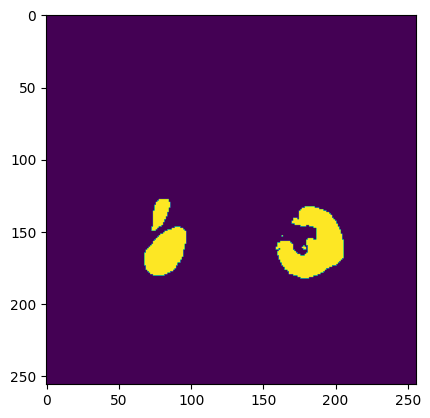

In [16]:
ct_nii = np.load('./preprocessed-data/masks/case_00122.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[10,:,:]
plt.imshow(test)

In [3]:
ct_nii = np.load('./preprocessed-data/images/case_00122.npy')
print(ct_nii.shape)
print(np.unique(ct_nii))
test = ct_nii[10,:,:]
plt.imshow(test)

NameError: name 'np' is not defined

(50, 512, 512)
[0. 1. 2.]


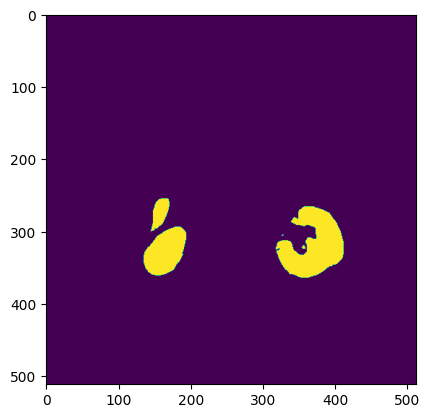

In [18]:
img = nib.load('../kits21/kits21/data/case_00122/aggregated_AND_seg.nii.gz')
print(img.shape)
data = img.get_fdata()
print(np.unique(data))
plt.imshow(data[27,:,:])

### Random test

In [19]:
img = nib.load('./preprocessed-data/images/case_00112.nii.gz')
print(img.shape)
data = img.get_fdata()
print(data.shape)


def resize_image_stack_and_flip(data):
    diff = data.shape[1] - data.shape[0]
    l, h = math.floor(diff/2), math.ceil(diff/2)
    print(diff, l, h)

    #a = front_padding, data, back_padding
    if data.shape[0] < data.shape[1]:
        print('padding image from {0} to {1}'.format(data.shape[0], data.shape[1]))
        empty_array = np.zeros([data.shape[1], data.shape[2]])
        front_padding, back_padding = np.array([empty_array]*l), np.array([empty_array]*h)
        resized_img = np.concatenate((front_padding, data))
        resized_img = np.concatenate((resized_img,back_padding))

    if data.shape[0] >= data.shape[1]:
        resized_img = data[-l:h].copy()
        
    #xz_slice = data[:, data.shape[1] // 2 - 1, :]
    #zx_slice = resized_img[:, :, resized_img.shape[-1] // 2 - 1]
        
    return resized_img

resized_img = resize_image_stack_and_flip(data)
print(resized_img.shape)

FileNotFoundError: No such file or no access: './preprocessed-data/images/case_00112.nii.gz'

In [20]:
middle_slice = resized_img[:, :, resized_img.shape[-1] // 2 - 1]
print(middle_slice.shape)
plt.imshow(middle_slice)
#plt.imshow(test)

NameError: name 'resized_img' is not defined

In [ ]:
yz_slice = data[img.shape[0] // 2 - 1, :, :]
print(yz_slice.shape)
plt.imshow(yz_slice)

In [ ]:
xz_slice = resized_img[:, resized_img.shape[1] // 2 - 1, :]
print(xz_slice.shape)

plt.imshow(xz_slice)

In [4]:
ct_nii = nib.load('./preprocessed-data/images/case_00140.nii.gz').get_fdata()
print(ct_nii.shape)
test = ct_nii[180,:,:]
plt.imshow(test)

FileNotFoundError: No such file or no access: './preprocessed-data/images/case_00140.nii.gz'

In [ ]:
ct_nii = nib.load('./preprocessed-data/images/case_00070.nii.gz').get_fdata()
print(ct_nii.shape)
test = ct_nii[40,:,:]
plt.imshow(test)

In [ ]:
ct_nii = nib.load('./preprocessed-data/images/case_00184.nii.gz').get_fdata()
print(ct_nii.shape)
test = ct_nii[20,:,:]
plt.imshow(test)

(103, 512, 512)


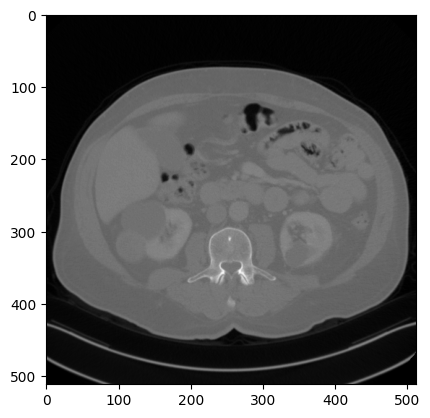

In [11]:
ct_nii = nib.load('../kits21/kits21/data/case_00200/imaging.nii.gz').get_fdata()
print(ct_nii.shape)
test = ct_nii[40,:,:]
plt.imshow(test, cmap = 'gray')